Import Libraries

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import time
from datetime import datetime
from sklearn import model_selection
from sklearn.svm import SVC, LinearSVR
from sklearn.linear_model import LassoLarsCV, RidgeCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PolynomialFeatures
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, mean_absolute_error, mean_squared_error, r2_score
from tpot.builtins import StackingEstimator
from xgboost import XGBRegressor
from atom import ATOMClassifier, ATOMRegressor, ATOMModel
from atom.feature_engineering import FeatureSelector

In [63]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [64]:
sns.set_theme(style="darkgrid")

Load Data

In [65]:
df = pd.read_csv('internet_session.csv')
print(df.shape)
df.head(10)

(4712, 9)


name           start_time   usage_time            IP                MAC  \
0  user1  2022-05-10 02:59:32  00:00:36:28  10.55.14.222  48:E7:DA:58:22:E9   
1  user1  2022-05-10 18:53:27  00:01:49:56   10.55.2.253  48:E7:DA:58:22:E9   
2  user1  2022-05-10 21:20:44  00:01:35:00   10.55.2.253  48:E7:DA:58:22:E9   
3  user1  2022-05-11 00:37:42  00:00:26:00   10.55.2.253  48:E7:DA:58:22:E9   
4  user1  2022-05-11 02:59:38  00:00:11:52   10.55.2.253  48:E7:DA:58:22:E9   
5  user1  2022-05-11 17:17:21  00:02:44:29   10.55.2.253  48:E7:DA:58:22:E9   
6  user1  2022-05-11 21:27:01  00:00:51:03   10.55.2.253  48:E7:DA:58:22:E9   
7  user1  2022-05-11 23:10:21  00:00:20:35   10.55.2.253  48:E7:DA:58:22:E9   
8  user1  2022-05-12 00:04:25  00:00:03:12   10.55.2.253  48:E7:DA:58:22:E9   
9  user1  2022-05-12 12:48:13  00:00:45:24    10.55.7.61  48:E7:DA:58:22:E9   

     upload   download  total_transfer seession_break_reason  
0  15861.76  333168.64       349030.40          Idle-Timeout  
1  16957.44  212152.32       229109.76          Idle-Timeout  
2   14080.0  195153.92       209233.92          Idle-Timeout  
3   5242.88    40806.4        46049.28          Idle-Timeout  
4   22067.2   10772.48        32839.68          Idle-Timeout  
5  39905.28  676167.68       716083.20          Idle-Timeout  
6    9472.0  166584.32       176056.32          Idle-Timeout  
7  11960.32  170977.28       182947.84          Idle-Timeout  
8   1146.88     3532.8         4679.68          Idle-Timeout  
9  12974.08   130764.8       143738.88          Idle-Timeout

Check the data types

In [66]:
print(df.dtypes)

name                      object
start_time                object
usage_time                object
IP                        object
MAC                       object
upload                    object
download                  object
total_transfer           float64
seession_break_reason     object
dtype: object


In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4712 entries, 0 to 4711
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   name                   4712 non-null   object 
 1   start_time             4712 non-null   object 
 2   usage_time             4712 non-null   object 
 3   IP                     4712 non-null   object 
 4   MAC                    4712 non-null   object 
 5   upload                 4712 non-null   object 
 6   download               4712 non-null   object 
 7   total_transfer         4712 non-null   float64
 8   seession_break_reason  4703 non-null   object 
dtypes: float64(1), object(8)
memory usage: 331.4+ KB


List all the columns

In [68]:
columns = df.columns
columns

Index(['name', 'start_time', 'usage_time', 'IP', 'MAC', 'upload', 'download',
       'total_transfer', 'seession_break_reason'],
      dtype='object')

check for null values in the dataset

In [69]:
df.isna().sum()

name                     0
start_time               0
usage_time               0
IP                       0
MAC                      0
upload                   0
download                 0
total_transfer           0
seession_break_reason    9
dtype: int64

Drop null value rows from the dataset

In [70]:
df = df.dropna().copy()
df.isna().sum()

name                     0
start_time               0
usage_time               0
IP                       0
MAC                      0
upload                   0
download                 0
total_transfer           0
seession_break_reason    0
dtype: int64

Convert data types of start time and usage time to data time format

In [71]:
df['usage_time'].astype(str)
df['usage_time'] = df['usage_time'].str.replace('00:', '', 1)
df['usage_time'] = pd.to_datetime(df['usage_time'])
df['start_time'] = pd.to_datetime(df['start_time'])
df.dtypes

name                             object
start_time               datetime64[ns]
usage_time               datetime64[ns]
IP                               object
MAC                              object
upload                           object
download                         object
total_transfer                  float64
seession_break_reason            object
dtype: object

In [72]:
df.head()

name          start_time          usage_time            IP  \
0  user1 2022-05-10 02:59:32 2023-02-04 00:36:28  10.55.14.222   
1  user1 2022-05-10 18:53:27 2023-02-04 01:49:56   10.55.2.253   
2  user1 2022-05-10 21:20:44 2023-02-04 01:35:00   10.55.2.253   
3  user1 2022-05-11 00:37:42 2023-02-04 00:26:00   10.55.2.253   
4  user1 2022-05-11 02:59:38 2023-02-04 00:11:52   10.55.2.253   

                 MAC    upload   download  total_transfer  \
0  48:E7:DA:58:22:E9  15861.76  333168.64       349030.40   
1  48:E7:DA:58:22:E9  16957.44  212152.32       229109.76   
2  48:E7:DA:58:22:E9   14080.0  195153.92       209233.92   
3  48:E7:DA:58:22:E9   5242.88    40806.4        46049.28   
4  48:E7:DA:58:22:E9   22067.2   10772.48        32839.68   

  seession_break_reason  
0          Idle-Timeout  
1          Idle-Timeout  
2          Idle-Timeout  
3          Idle-Timeout  
4          Idle-Timeout

In [73]:
df.describe(include='all', datetime_is_numeric=True)

name                     start_time                     usage_time  \
count    4703                           4703                           4703   
unique      9                            NaN                            NaN   
top     user4                            NaN                            NaN   
freq      725                            NaN                            NaN   
mean      NaN  2022-08-08 09:35:44.875185920  2023-02-04 02:10:05.038486016   
min       NaN            2022-05-09 22:52:41            2023-02-04 00:00:01   
25%       NaN     2022-06-14 18:33:06.500000            2023-02-04 00:31:42   
50%       NaN            2022-08-19 13:56:28            2023-02-04 01:19:40   
75%       NaN     2022-09-24 22:30:58.500000            2023-02-04 02:49:02   
max       NaN            2022-11-05 18:41:14            2023-02-04 22:00:07   
std       NaN                            NaN                            NaN   

                IP                MAC  upload   download  total_transfer  \
count         4703               4703    4703       4703    4.703000e+03   
unique        1299                 33    2913       3724             NaN   
top     10.55.0.89  48:E7:DA:58:22:E9  5222.4  1310720.0             NaN   
freq            80               1235       8         10             NaN   
mean           NaN                NaN     NaN        NaN    4.304372e+05   
min            NaN                NaN     NaN        NaN    1.120000e+00   
25%            NaN                NaN     NaN        NaN    6.187008e+04   
50%            NaN                NaN     NaN        NaN    2.027930e+05   
75%            NaN                NaN     NaN        NaN    4.993997e+05   
max            NaN                NaN     NaN        NaN    2.855272e+07   
std            NaN                NaN     NaN        NaN    9.960848e+05   

       seession_break_reason  
count                   4703  
unique                     5  
top             Idle-Timeout  
freq                    4350  
mean                     NaN  
min                      NaN  
25%                      NaN  
50%                      NaN  
75%                      NaN  
max                      NaN  
std                      NaN

In [74]:
df.name.value_counts()

user4    725
user6    674
user1    673
user9    571
user7    526
user3    518
user2    456
user5    335
user8    225
Name: name, dtype: int64

Q1) Check the internet usage in a day

In [77]:
df['hour'] = df['start_time'].dt.hour
activity = df['hour'].value_counts().sort_index()

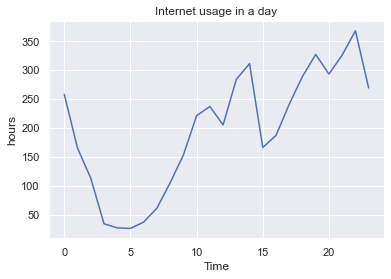

In [80]:
plt.figure()
plt.plot(activity)
plt.xlabel("Time")
plt.ylabel("hours")
plt.title("Internet usage in a day")
plt.show()

In [85]:
a1 = list(activity).index(max(list(activity)))
print('The most frequent internet activity time of the day is {}h'.format(a1))

The most frequent internet activity time of the day is 22h


Q2) Check IP addresses changes

In [89]:
start_ip = '48:E7:DA:58:22:E9'
ip_count = 0
for i in range(1, df.shape[0]):
    if df.iloc[i]['IP'] != start_ip:
        ip_count +=1
        start_ip = df.iloc[i]['IP']

print('The IP Adress changed ' + str(ip_count) + ' times') 

The IP Adress changed 2303 times


Adding device column info to the dataset

In [91]:
device = []
basename = 'device'
mac = df['MAC'][0]
device_number = 1
for i in df['MAC']:
    if i == mac:
        device.append(basename + str(device_number))
    else:
        device_number += 1
        device.append(basename + str(device_number))
        mac = i
df['device'] = device

Q3) Check device changes

In [92]:
start_device = 'device1'
device_count = 0
for i in range(1, df.shape[0]):
    if df.iloc[i]['device'] != start_device:
        device_count +=1
        start_device = df.iloc[i]['device']

print('The device changed ' + str(device_count) + ' times') 

The device changed 1223 times


Q4) Calculate average usage per hour

In [93]:
df.reset_index(inplace=True)
df['day'] = df['start_time'].dt.day
df['month'] = df['start_time'].dt.month
hourly_average = df.groupby('hour').total_transfer.mean()
print('The Average usage per hour is:\n ' +  str(round(hourly_average, 2)))

The Average usage per hour is:
 hour
0     464530.44
1     530880.86
2     431576.11
3     345303.34
4     359809.44
5     275960.91
6     468959.59
7     292886.83
8     366681.92
9     377480.64
10    393259.12
11    309492.45
12    310137.98
13    335270.58
14    472403.71
15    517005.11
16    403919.40
17    525423.69
18    666590.76
19    389841.79
20    355862.80
21    474038.34
22    449600.50
23    407785.08
Name: total_transfer, dtype: float64


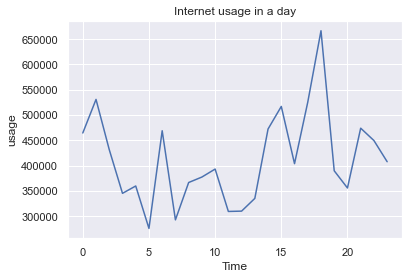

In [98]:
plt.figure()
plt.plot(hourly_average)
plt.xlabel("Time")
plt.ylabel("usage")
plt.title("Internet usage in a day")
plt.show()

Q4) Calculate average usage per day

In [95]:
daily_average = df.groupby('day').total_transfer.mean()
print('The Average usage per day is:\n ' +  str(round(daily_average, 2)))

The Average usage per day is:
 day
1     396705.04
2     494496.48
3     445865.63
4     676332.03
5     652195.66
6     396261.75
7     402259.89
8     301859.57
9     393521.97
10    350665.02
11    729857.65
12    346695.95
13    501906.70
14    352701.10
15    521520.51
16    426719.39
17    475795.71
18    337490.93
19    301941.32
20    365130.12
21    462211.69
22    486595.37
23    383153.93
24    320598.94
25    443689.47
26    463432.02
27    324318.12
28    494576.34
29    363645.61
30    361418.88
31    369118.01
Name: total_transfer, dtype: float64


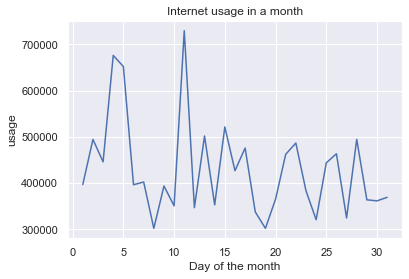

In [100]:
plt.figure()
plt.plot(daily_average)
plt.xlabel("Day of the month")
plt.ylabel("usage")
plt.title("Internet usage in a month")
plt.show()

Q4) Calculate average usage per month

In [96]:
monthly_average = df.groupby('month').total_transfer.mean()
print('The Average usage per month is:\n ' +  str(round(monthly_average, 2)))

The Average usage per month is:
 month
5     311177.16
6     338418.08
7     418583.99
8     479042.44
9     482955.52
10    549467.63
11    399804.11
Name: total_transfer, dtype: float64


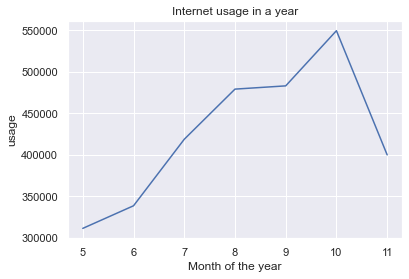

In [101]:
plt.figure()
plt.plot(monthly_average)
plt.xlabel("Month of the year")
plt.ylabel("usage")
plt.title("Internet usage in a year")
plt.show()